## WB Homework 3 
Agata Kaczmarek

Sources of model and knowledge:
- [Data](https://www.kaggle.com/datasets/gpiosenka/sports-classification)
- [Model](https://www.kaggle.com/code/m0riarty/resnet50)
- [Notes from lab](https://github.com/MI2-Education/2022L-WB-XIC/tree/main/labs)
- [Captum](https://captum.ai/api/lime) 
- [PyTorch](https://pytorch.org/docs/stable/notes/serialization.html#recommend-saving-models)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from  torchvision.datasets import ImageFolder 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy

At the beginning, I had an idea to train the model on GPU, but at the end of the day - trained on CPU (what required a looot of patience :)).

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Dataset is about various sports. Downloaded datasets are divided into three folders: train, test and valid. Each of them consists of 100 folders with names of classes (the same for all three folders), where are stored all images. Whole set consists of over 13000 pictures. I tried training a net on all of them, but after about 11h of training, I gave up and interrupted, so the net is trained on about 6000 images, split into 100 classes.

In [5]:
transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5)),
])

train_set = ImageFolder('C:/Users/akaga/Python_for_classes/env_for_ml_st/archive/train', transform = transform)
test_set = ImageFolder('C:/Users/akaga/Python_for_classes/env_for_ml_st/archive/test', transform = transform)
valid_set = ImageFolder('C:/Users/akaga/Python_for_classes/env_for_ml_st/archive/valid', transform = transform)

[ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) is a "magical" data loader, which is very useful, while loading data from various folders.

In [53]:
train_set

Dataset ImageFolder
    Number of datapoints: 13572
    Root location: C:/Users/akaga/Python_for_classes/env_for_ml_st/archive/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

A bit of processing of classes names - each name of a class is a name of a folder in which photos are stored. As we can see, quite a lot of various disciplines, from swimming to hockey.

In [6]:
import os

folder = 'C:/Users/akaga/Python_for_classes/env_for_ml_st/archive/train'

classes = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]

print(classes)

['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbing', 'roller 

In [8]:
num_classes = 100

In [9]:
from torchvision import models

Below function to evaluate the model, used while training to see, how is it going, if the model is not overfitting. Additional, parts from inside of that function were used later, to see the accuracy on batches from train, test and validation set, to proof, that the model is not overfitted.

In [13]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total


Model used here is a pretrained ResNet50, with CrossEntropyLoss and Adam as an optimizer. On alredy linked website, it was proposed to do 4 epochs, but it took too long for my computer, so I decided to interrupt before the end of first epoch, however, even though, the results seems to be good. Especially, as we have so many classes.

In [10]:
batch_size = 16

iterations = []
accuracies = []
losses = []

trainloader = DataLoader(train_set, batch_size = batch_size, shuffle =  True)
valloader = DataLoader(valid_set, batch_size = batch_size, shuffle = True)
testloader = DataLoader(test_set, batch_size = batch_size, shuffle = True)

model = torchvision.models.resnet50(pretrained = True)

for param in model.parameters():
    param.required_grad = False

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr = 0.0001)

loss_epoch_arr = []
max_epochs = 4

min_loss = 1000000

n_iters = np.ceil(10436/batch_size)*max_epochs
iters = 0

In [15]:
batch_size = 16

iterations = []
accuracies = []
losses = []

trainloader = DataLoader(train_set, batch_size = batch_size, shuffle =  True)
valloader = DataLoader(valid_set, batch_size = batch_size, shuffle = True)
testloader = DataLoader(test_set, batch_size = batch_size, shuffle = True)

model = torchvision.models.resnet50(pretrained = True)

for param in model.parameters():
    param.required_grad = False

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr = 0.0001)

loss_epoch_arr = []
max_epochs = 4

min_loss = 1000000

n_iters = np.ceil(10436/batch_size)*max_epochs
iters = 0

# for epoch in range(max_epochs):

#     for i, data in enumerate(trainloader, 0):
#         iters += 1
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)

#         opt.zero_grad()

#         outputs = model(inputs)
#         loss = loss_fn(outputs, labels)
#         loss.backward()
#         opt.step()
        
#         if iters % 1 == 0:
#             curAccuracy =  evaluation(valloader, model)
#             curLoss = loss.item()
#             iterations.append(iters)
#             accuracies.append(curAccuracy)
#             losses.append(curLoss)
#             print('Iteration: %d/%d, Loss: %0.2f, Validation acc: %0.2f'%(iters,n_iters, curLoss, curAccuracy))

#         del inputs, labels, outputs
#         torch.cuda.empty_cache()
#     loss_epoch_arr.append(loss.item())
#     print('Epoch: %d/%d ended. Validation acc: %0.2f, Train acc: %0.2f' % (
#       epoch+1, max_epochs, 
#       evaluation(valloader, model), 
#       evaluation(trainloader, model)))
    
# print('\n\nTest Accuarcy on final model: %0.4f' % evaluation(testloader, model))

Iteration: 1/2612, Loss: 4.57, Validation acc: 1.60
Iteration: 2/2612, Loss: 4.58, Validation acc: 2.20
Iteration: 3/2612, Loss: 4.50, Validation acc: 3.20
Iteration: 4/2612, Loss: 4.46, Validation acc: 2.80
Iteration: 5/2612, Loss: 4.97, Validation acc: 5.20
Iteration: 6/2612, Loss: 4.70, Validation acc: 4.20
Iteration: 7/2612, Loss: 4.52, Validation acc: 5.60
Iteration: 8/2612, Loss: 4.45, Validation acc: 6.80
Iteration: 9/2612, Loss: 4.33, Validation acc: 6.20
Iteration: 10/2612, Loss: 4.60, Validation acc: 6.60
Iteration: 11/2612, Loss: 4.37, Validation acc: 8.20
Iteration: 12/2612, Loss: 4.60, Validation acc: 9.20
Iteration: 13/2612, Loss: 4.77, Validation acc: 8.80
Iteration: 14/2612, Loss: 4.65, Validation acc: 10.20
Iteration: 15/2612, Loss: 4.76, Validation acc: 9.60
Iteration: 16/2612, Loss: 4.22, Validation acc: 10.20
Iteration: 17/2612, Loss: 4.26, Validation acc: 10.00
Iteration: 18/2612, Loss: 4.36, Validation acc: 11.00
Iteration: 19/2612, Loss: 4.62, Validation acc: 12.

KeyboardInterrupt: 

In case anything goes wrong while doing this homework (and to later be able to open it fast), I wrote to file both trained model and informations from first batch from testloader - images (inputs), labels and predicted labels. It also helped me to make the pictures, which I explain, everytime the same, so I was able to draw some conclusions.

In [47]:
filename = 'finalized_model10.pth'
torch.save(model, filename)

In [12]:
filename = 'finalized_model10.pth'
loaded_model=torch.load(filename)
type(loaded_model)

torchvision.models.resnet.ResNet

Checking scores on validation, train and test set. Model seems not to be overfitted.

In [79]:
# score on validation set


# total=0
# correct=0
# inputs, labels = next(iter(valloader))
# inputs, labels = inputs.to(device), labels.to(device)
# outputs = loaded_model(inputs)
# _, pred = torch.max(outputs.data, 1)
# total += labels.size(0)
# correct += (pred == labels).sum().item()
# print(100 * correct / total)


81.25


In [75]:
#score on train set

# total=0
# correct=0
# inputs, labels = next(iter(trainloader))
# inputs, labels = inputs.to(device), labels.to(device)
# outputs = loaded_model(inputs)
# _, pred = torch.max(outputs.data, 1)
# total += labels.size(0)
# correct += (pred == labels).sum().item()
# print(100 * correct / total)


81.25


In [82]:
#score on test set
# total=0
# correct=0
# inputs, labels = next(iter(testloader))
# inputs, labels = inputs.to(device), labels.to(device)
# outputs = loaded_model(inputs)
# _, pred = torch.max(outputs.data, 1)
# total += labels.size(0)
# correct += (pred == labels).sum().item()
# print(100 * correct / total)


75.0


In [89]:
# #save inputs, labels and prediction

# torch.save(inputs, 'input_to_analyze.pt')
# torch.save(labels, 'labels_to_analyze.pt')
# torch.save(pred, 'pred_to_analyze.pt')

In [16]:
#reading from files
inputs=torch.load('input_to_analyze.pt')
labels=torch.load('labels_to_analyze.pt')
pred=torch.load('pred_to_analyze.pt')

Additionaly, the size of photos is 224 x 224, and the total number of images in train set is over 13000 (however, as stated before, not all were used).

In [17]:
inputs.size()

torch.Size([16, 3, 224, 224])

In [84]:
print(f"batch number: {len(trainloader)}, batch size: {batch_size}, all together, number of images in train set: {len(trainloader)*batch_size}") #trainloader contains len(trainloader) batches, each batch has 16 images

batch number: 849, batch size: 16, all together, number of images in train set: 13584


Pictures and both true and predicted labels for earlier saved batch from test set. Images seems to be in good resolution, in most cases, we can easily say which sport is on the picture. However, due to the normalization at the beginning, some of the photos seems to be a bit too dark. In this batch, we have 12 correct predicted and 4 false labels.

torch.Size([16, 3, 224, 224])
tensor([66, 69, 98, 63, 50, 41, 61, 18, 79, 98, 60, 20, 91, 92,  7, 36])
tensor([66, 69, 98, 62, 50, 41, 61, 84, 47, 88, 60, 20, 91, 92,  7, 36])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: rings, pred: rings
label: rollerblade racing, pred: rollerblade racing
label: wheelchair racing, pred: wheelchair racing
label: pole vault, pred: pole dancing
label: javelin, pred: javelin
label: hockey, pred: hockey
label: pole climbing, pred: pole climbing
label: canoe slamon, pred: surfing
label: snow boarding, pred: ice climbing
label: wheelchair racing, pred: track bicycle
label: parallel bar, pred: parallel bar
label: chuckwagon racing, pred: chuckwagon racing
label: ultimate, pred: ultimate
label: uneven bars, pred: uneven bars
label: baseball, pred: baseball
label: golf, pred: golf


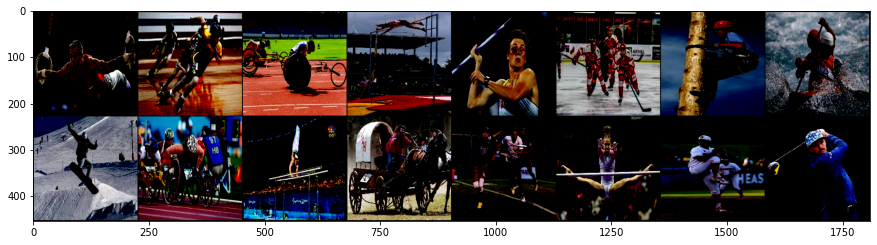

In [64]:
print(inputs.shape)
print(labels)
print(pred)
grid_testing = torchvision.utils.make_grid(inputs, nrow=8)

plt.figure(figsize=(15,15))
plt.imshow(grid_testing.permute(1,2,0))

for i in range(batch_size):
    print(f"label: {classes[labels[i]]}, pred: {classes[pred[i]]}")

In some of the cases, I think I would also have problems with recognizing, what is happening on the pictures, for example on a picture in bottom row, between horses and gimnastics girl. Additionaly, for the second one (rollerblade racing), I was surprised, that the model did it good, as the rolls are hardly visible. What is interesting, model made a mistake with the picture with snowboard - for me it is clearly visible, so later I will take a look at the explanation of a model - maybe it will help me understand, why it decided to predict 'ice climbing' instead of 'snowboarding'.

### Visualization of 6 choosen photos, each explained with 3 methods

Below I present 6 good classified photos, with their explanation. Each of them was explained with the same three methods. I might have used function to do the calculations and printing, as they were in all cases similar, but I decided not to, as in this way, results of each part of code are shown directly below it, so this will help in coming back to this code while doing a project. Methods used are: LIME, IntegratedGradients and SHAP.

### First good

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
true label: rings
pred label: rings
tensor(66)


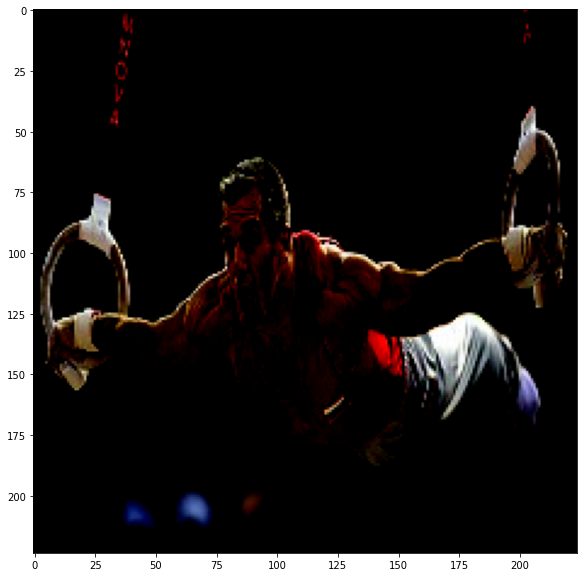

In [145]:
print(type(inputs[1]))

grid_test = torchvision.utils.make_grid(inputs[0], nrow=10)

plt.figure(figsize=(10,10))
plt.imshow(grid_test.cpu().permute(1,2,0))

print(f'true label: {classes[labels[0]]}')
print(f'pred label: {classes[pred[0]]}')
print(labels[0])

For me very dark picture, however still visible. I was curious, what made model think it is sport called 'rings'. I thought it were this round rings, but let's see...

In [19]:
#explanations

from captum.attr import Lime
from captum.attr import IntegratedGradients

In [253]:
explainer_0 = Lime(loaded_model)
mask_0 = segmentation.quickshift(
    inputs[0].permute(1, 2, 0).double(), 
    kernel_size=25, 
    max_dist=7, 
    ratio=0.7
  )

In [254]:
mask_0

array([[  47,   47,   47, ...,   72,   72,   72],
       [  47,   47,   47, ...,   72,   72,   72],
       [  47,   47,   47, ...,   72,   72,   72],
       ...,
       [ 961,  961,  961, ..., 1014, 1014, 1014],
       [ 961,  961,  961, ..., 1014, 1014, 1014],
       [ 961,  961,  961, ..., 1014, 1014, 1014]], dtype=int64)

In [267]:
attr_0 = explainer_0.attribute(
    inputs[0].unsqueeze(0),
    target=66, 
    n_samples=20, 
    feature_mask=torch.as_tensor(mask_0),
    show_progress=True
  )

Lime attribution: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]


In [268]:
np.max(attr_0.tolist())

0.007658614311367273

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


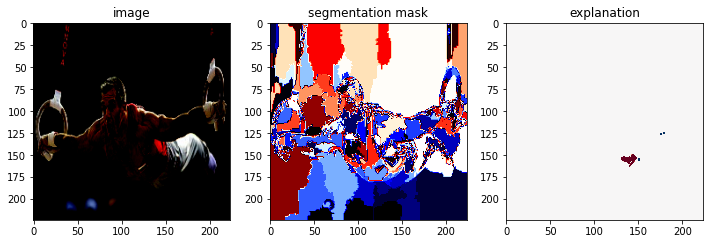

In [270]:
show_image_mask_explanation(inputs[0], mask_0, attr_0[0].mean(axis=0)*100000)

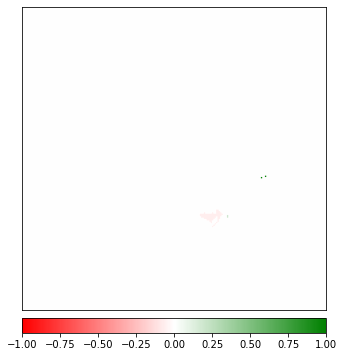

In [271]:
show_attr(attr_0[0])

According to the LIME explanation, it seems as this prediction was some kind of random guess, as the explanation shows something in the surrounding of part of a feet of a men, for sure not rings.

In [497]:
exp_ig_0 = IntegratedGradients(loaded_model)

attr_ig_0 = exp_ig_0.attribute(inputs[0].unsqueeze(0), target=66)

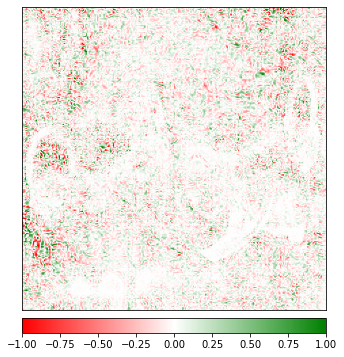

In [498]:
show_attr(attr_ig_0[0])

For IntegratedGradients still not so much information (but much more than for LIME). There are no 'special places', which, as a whole part, made model to decide. What is interesting, the rings can be seen on the picture, but as a neutral surface, the one that has neither positive nor negative influence on the prediction.

Kernel Shap attribution: 100%|██████████| 300/300 [00:48<00:00,  6.24it/s]


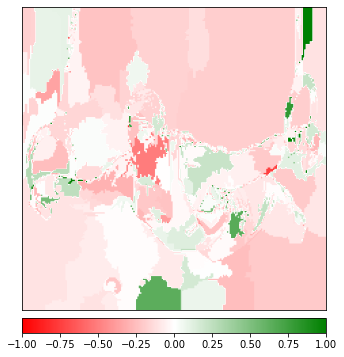

In [500]:
from captum.attr import KernelShap
exp_ks_0_2 = KernelShap(loaded_model)

exp_ks_0_2 = exp_ks_0_2.attribute(
    inputs[0].unsqueeze(0), 
    target=66, 
    n_samples=300, 
    feature_mask=torch.as_tensor(mask_0),
    show_progress=True
  )

show_attr(exp_ks_0_2[0])

Only SHAP seems to be explaining the images, as we would. It seems to say something about rings (green visible parts of both rings) and position of a body (horizontal, not vertical).

### Second good

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: wheelchair racing
true label: wheelchair racing
tensor(98)


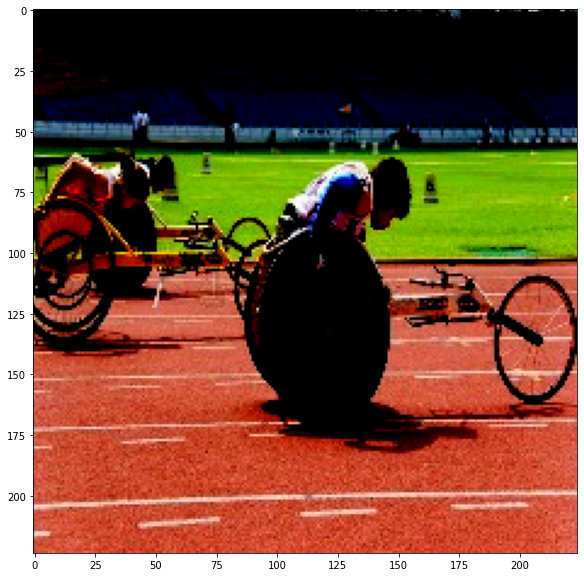

In [106]:
grid_test = torchvision.utils.make_grid(inputs[2], nrow=10)

plt.figure(figsize=(10,10))
plt.imshow(grid_test.cpu().permute(1,2,0))

print(f'true label: {classes[labels[2]]}')
print(f'true label: {classes[pred[2]]}')
print(labels[2])

This picture seems to be characteristic, as it clearly shows people on wheelschairs and doing some sports, so I was thinking, that wheels will be the most important part for model to make the decision.

In [245]:
from skimage import segmentation
explainer_1 = Lime(loaded_model)
mask_1 = segmentation.quickshift(
    inputs[2].permute(1, 2, 0).double(), 
    kernel_size=20, 
    max_dist=7, 
    ratio=0.5
  )

In [246]:
mask_1

array([[  12,   12,   12, ...,    7,    7,    7],
       [  12,   12,   12, ...,   15,   15,    7],
       [  12,   12,   12, ...,   15,   15,   15],
       ...,
       [1188, 1188, 1188, ..., 1195, 1195, 1195],
       [1188, 1188, 1188, ..., 1195, 1195, 1195],
       [1188, 1188, 1188, ..., 1195, 1195, 1195]], dtype=int64)

In [247]:
attr_1 = explainer_1.attribute(
    inputs[2].unsqueeze(0),
    target=98, 
    n_samples=20, 
    feature_mask=torch.as_tensor(mask_1),
    show_progress=True
  )

Lime attribution: 100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


In [248]:
np.max(attr_1.tolist())

0.022972138598561287

In [26]:
def show_image_mask_explanation(image, mask, explanation):
    fig, ax = plt.subplots(1, 3, figsize=[6 * 2, 6])
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title("image")
    ax[1].imshow(mask, cmap="flag")
    ax[1].set_title("segmentation mask")
    ax[2].imshow(explanation, vmin=-1, vmax=1, cmap="RdBu")
    ax[2].set_title("explanation")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


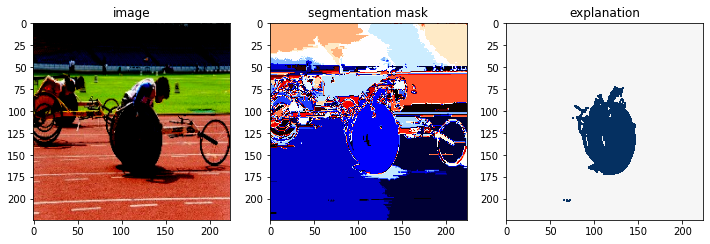

In [250]:
show_image_mask_explanation(inputs[2], mask_1, attr_1[0].mean(axis=0)*1000000)

In [25]:
from captum.attr import visualization

def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

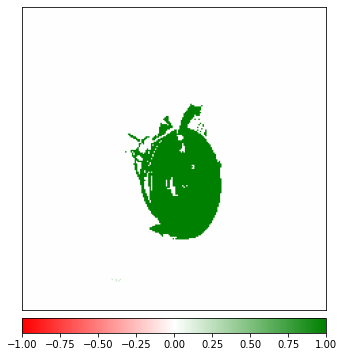

In [251]:
show_attr(attr_1[0])

As previously assumed, even LIME showed, that wheel, the one in the main part of the picture, the biggest, had the most positive influence, to classify this image as 'wheelchair racing'.

In [483]:
from captum.attr import IntegratedGradients
exp_ig_1 = IntegratedGradients(loaded_model)

attr_ig_1 = exp_ig_1.attribute(inputs[2].unsqueeze(0), target=98)

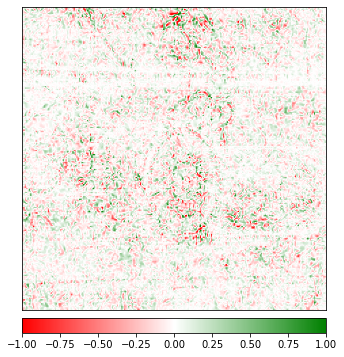

In [484]:
show_attr(attr_ig_1[0])

For IntegratedGradients method, we can also see shape of a wheel, even being green, as having possitive influence, however, the picture is chaotic.

Kernel Shap attribution: 100%|██████████| 300/300 [00:45<00:00,  6.52it/s]


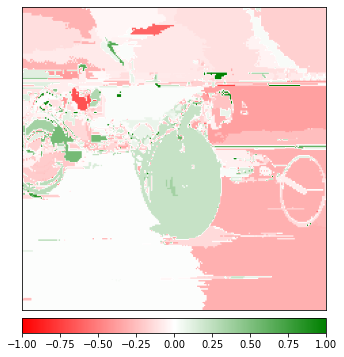

In [487]:
from captum.attr import KernelShap
exp_ks_1_1 = KernelShap(loaded_model)

exp_ks_1_1 = exp_ks_1_1.attribute(
    inputs[2].unsqueeze(0), 
    target=98, 
    n_samples=300, 
    feature_mask=torch.as_tensor(mask_1),
    show_progress=True
  )

show_attr(exp_ks_1_1[0])

In this case also in SHAP method we can clearly see even more than one wheel, all coloured in green, so having positive impact. I think it is one of the best results of explanations done for this model in this file.

### Third good

People doing 'rollerblade racing'. I was surprised, that the model was right for this picture, as the rollers are hardly visible. I hoped, that the explanation will show the rollers...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: rollerblade racing
true label: rollerblade racing
tensor(69)


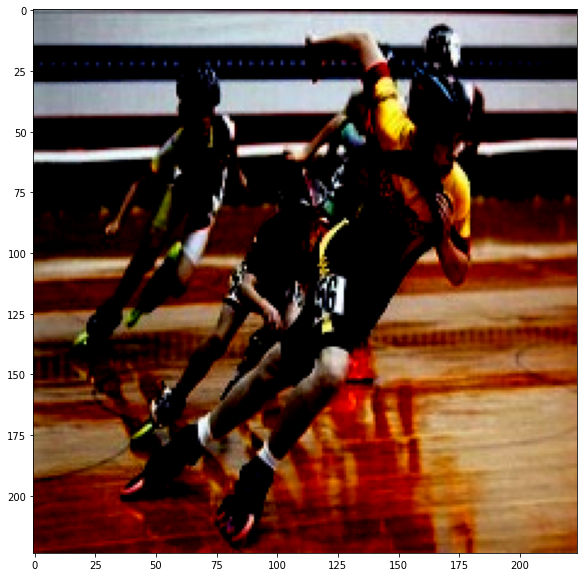

In [496]:
grid_test = torchvision.utils.make_grid(inputs[1], nrow=10)

plt.figure(figsize=(10,10))
plt.imshow(grid_test.cpu().permute(1,2,0))

print(f'true label: {classes[labels[1]]}')
print(f'true label: {classes[pred[1]]}')
print(labels[1])

In [501]:
explainer_3= Lime(loaded_model)
mask_3 = segmentation.quickshift(
    inputs[1].permute(1, 2, 0).double(), 
    kernel_size=25, 
    max_dist=7, 
    ratio=0.7
  )

In [502]:
attr_3 = explainer_3.attribute(
    inputs[1].unsqueeze(0),
    target=69, 
    n_samples=20, 
    feature_mask=torch.as_tensor(mask_3),
    show_progress=True
  )

Lime attribution: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]


In [503]:
np.max(attr_3.tolist())

0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


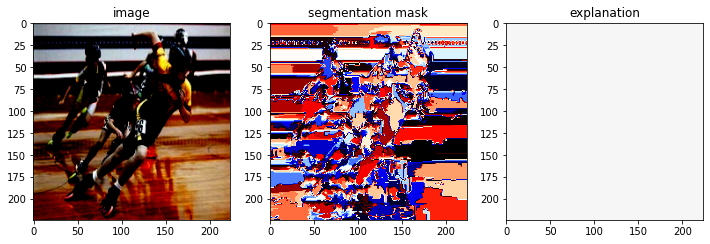

In [507]:
show_image_mask_explanation(inputs[1], mask_3, attr_3[0].mean(axis=0)*1000000)

For LIME method, it did not even work, as if model was not even trying to classify this picture to a class, based on some kind of observation on an image, but just guessed or so.

In [509]:
exp_ig_3 = IntegratedGradients(loaded_model)
attr_ig_3 = exp_ig_3.attribute(inputs[1].unsqueeze(0), target=69)

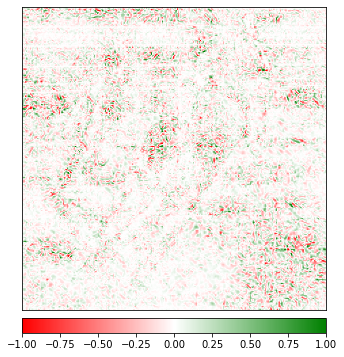

In [510]:
show_attr(attr_ig_3[0])

For this method, we can hardly see anything, when we know, what is on that picture, we could think of straight lines, being legs of mens, but that is it.

Kernel Shap attribution: 100%|██████████| 500/500 [01:21<00:00,  6.13it/s]


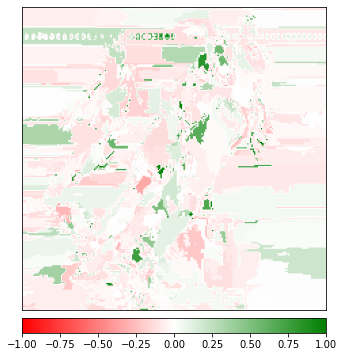

In [514]:
exp_ks_3_1 = KernelShap(loaded_model)

exp_ks_3_1 = exp_ks_3_1.attribute(
    inputs[1].unsqueeze(0), 
    target=69, 
    n_samples=500, 
    feature_mask=torch.as_tensor(mask_3),
    show_progress=True
  )

show_attr(exp_ks_3_1[0])

Even explanation of a SHAP for this method, does not seems to make much of a sense. We can see some parts of people, for sure nothing, which seems to  be rollers. For me it was a bit disappointing example.

### Fourth good

This one seems to on one hand, have a potential of being good explained, as the javelin is clearly visible, however, on the other hand - javelin is small on the picture.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: javelin
true label: javelin
tensor(50)


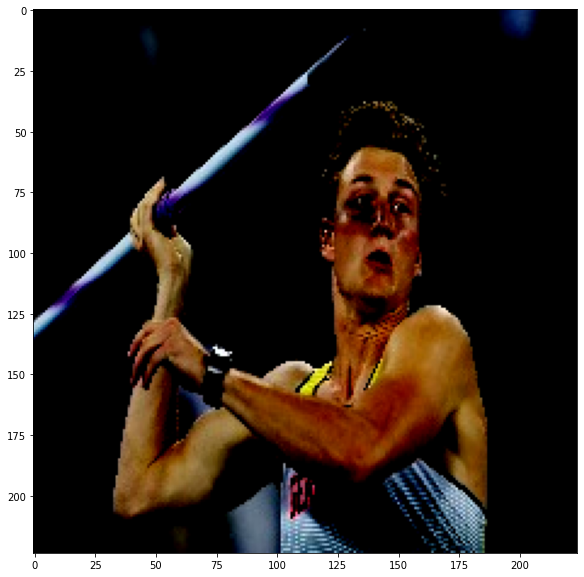

In [20]:
grid_test = torchvision.utils.make_grid(inputs[4], nrow=10)

plt.figure(figsize=(10,10))
plt.imshow(grid_test.cpu().permute(1,2,0))

print(f'true label: {classes[labels[4]]}')
print(f'true label: {classes[pred[4]]}')
print(labels[4])

In [22]:
from skimage import segmentation
explainer_4= Lime(loaded_model)
mask_4 = segmentation.quickshift(
    inputs[4].permute(1, 2, 0).double(), 
    kernel_size=25, 
    max_dist=7, 
    ratio=0.7
  )

In [23]:
attr_4 = explainer_4.attribute(
    inputs[4].unsqueeze(0),
    target=50, 
    n_samples=20, 
    feature_mask=torch.as_tensor(mask_4),
    show_progress=True
  )
np.max(attr_4.tolist())

Lime attribution: 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


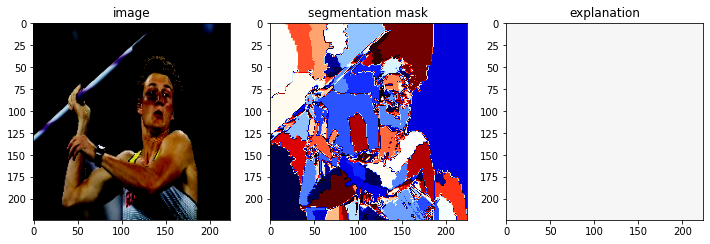

In [27]:
show_image_mask_explanation(inputs[4], mask_4, attr_4[0].mean(axis=0)*1000000)

Also in this case, LIME had problems with saying at least anything...

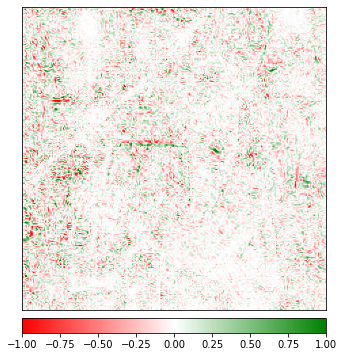

In [55]:
exp_ig_4 = IntegratedGradients(loaded_model)
attr_ig_4 = exp_ig_4.attribute(inputs[4].unsqueeze(0), target=50)
show_attr(attr_ig_4[0])

Still messy IntegratedGradients, however, javeling clearly seen as a neutral surface.

Kernel Shap attribution: 100%|██████████| 500/500 [01:23<00:00,  5.99it/s]


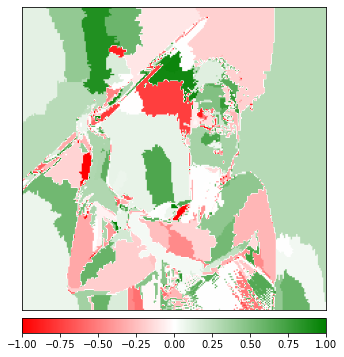

In [30]:
from captum.attr import KernelShap
exp_ks_4_1 = KernelShap(loaded_model)

exp_ks_4_1 = exp_ks_4_1.attribute(
    inputs[4].unsqueeze(0), 
    target=50, 
    n_samples=500, 
    feature_mask=torch.as_tensor(mask_4),
    show_progress=True
  )

show_attr(exp_ks_4_1[0])

Finally, in SHAP method, some interesting results can be seen. From colors of this explanation we can easily assume, that on this picture is a human with javelin. Additionaly, the colors are in such possitions, that we can say, that it makes logical sense.

### Fifth good

Three hockey players and someoune, probably referee, between them. Referee makes the picture less readable, as he is wearing dark clothes. Hopefully, even though the model can explain itself, why the prediction is good.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: hockey
true label: hockey
tensor(41)


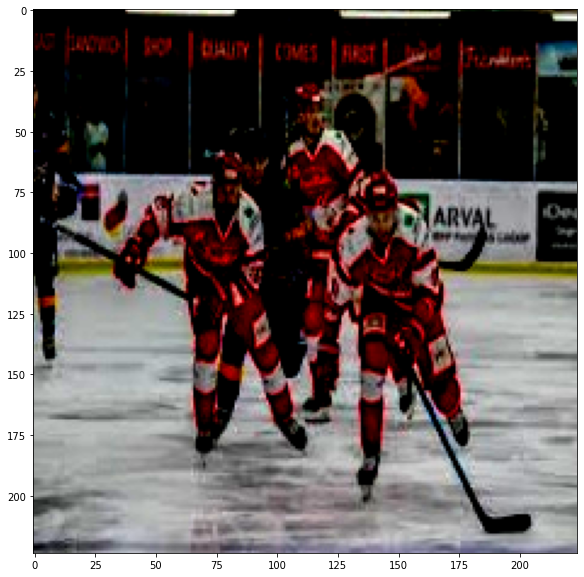

In [31]:
grid_test = torchvision.utils.make_grid(inputs[5], nrow=10)

plt.figure(figsize=(10,10))
plt.imshow(grid_test.cpu().permute(1,2,0))

print(f'true label: {classes[labels[5]]}')
print(f'true label: {classes[pred[5]]}')

print(labels[5])

In [48]:
explainer_5= Lime(loaded_model)
mask_5 = segmentation.quickshift(
    inputs[5].permute(1, 2, 0).double(), 
    kernel_size=20, 
    max_dist=25, 
    ratio=1.0
  )

In [50]:
attr_5 = explainer_5.attribute(
    inputs[5].unsqueeze(0),
    target=41, 
    n_samples=20, 
    feature_mask=torch.as_tensor(mask_5),
    show_progress=True
  )
np.max(attr_5.tolist())

Lime attribution: 100%|██████████| 20/20 [00:02<00:00,  7.01it/s]


0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


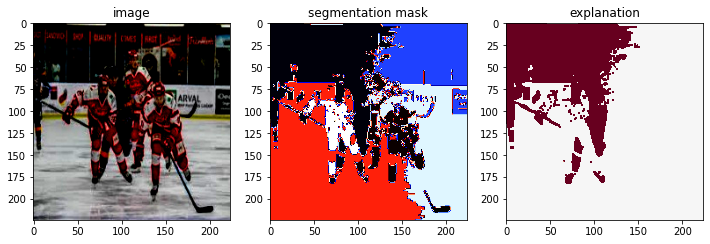

In [53]:
show_image_mask_explanation(inputs[5], mask_5, attr_5[0].mean(axis=0)*1000000)

Surprisingly, we can see an interesting pattern on LIME explanation, as there seems to be one of the players visible.

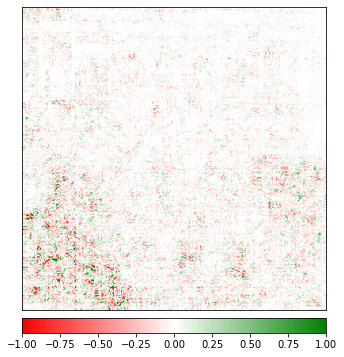

In [56]:
from captum.attr import IntegratedGradients
exp_ig_5 = IntegratedGradients(loaded_model)
attr_ig_5 = exp_ig_5.attribute(inputs[5].unsqueeze(0), target=41)
show_attr(attr_ig_5[0])

In this method, still essy, only we can say thet the left bottom corner had more impact on the decidion of a model - of course according to IntegratedGradients explanations.

Kernel Shap attribution: 100%|██████████| 500/500 [01:15<00:00,  6.61it/s]


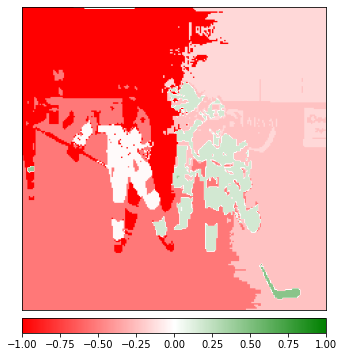

In [57]:
exp_ks_5_1 = KernelShap(loaded_model)

exp_ks_5_1 = exp_ks_5_1.attribute(
    inputs[5].unsqueeze(0), 
    target=41, 
    n_samples=500, 
    feature_mask=torch.as_tensor(mask_5),
    show_progress=True
  )

show_attr(exp_ks_5_1[0])

Finally SHAP, logically the explanation makes sense, there are two players in green and even one of the hockey sticks. The hockeysticks is the most green thing there, so had biggest good impact, that makes sense.

### Sixth good

Being hones, I di not know about this sport before. The picture seems to be readable, especially 'pipe' and helmet. Let's what the explainers said.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: pole climbing
true label: pole climbing
tensor(61)


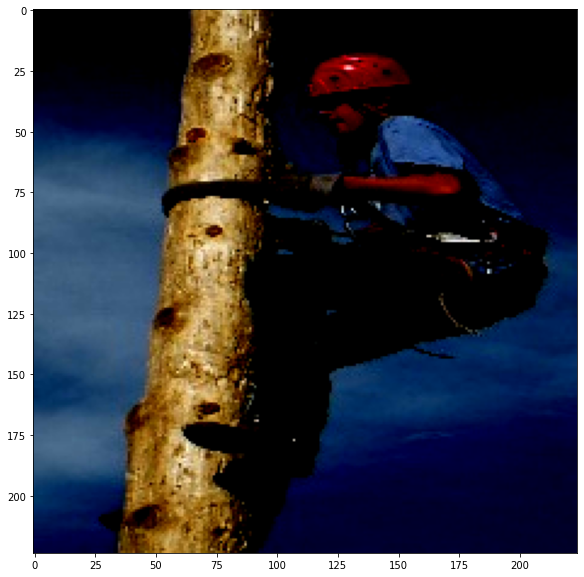

In [110]:
grid_test = torchvision.utils.make_grid(inputs[6], nrow=10)

plt.figure(figsize=(10,10))
plt.imshow(grid_test.cpu().permute(1,2,0))

print(f'true label: {classes[labels[6]]}')
print(f'true label: {classes[pred[6]]}')
print(labels[6])

In [58]:
explainer_6= Lime(loaded_model)
mask_6 = segmentation.quickshift(
    inputs[6].permute(1, 2, 0).double(), 
    kernel_size=20, 
    max_dist=25, 
    ratio=1.0
  )

In [59]:
attr_6 = explainer_6.attribute(
    inputs[6].unsqueeze(0),
    target=61, 
    n_samples=20, 
    feature_mask=torch.as_tensor(mask_6),
    show_progress=True
  )
np.max(attr_6.tolist())

Lime attribution: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


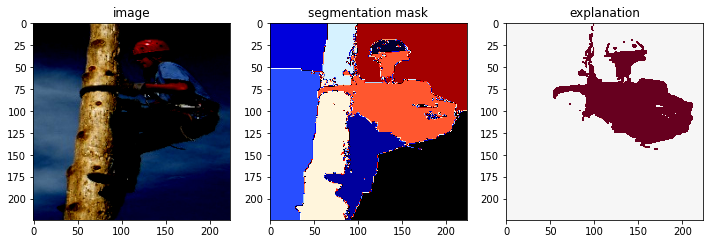

In [60]:
show_image_mask_explanation(inputs[6], mask_6, attr_6[0].mean(axis=0)*1000000)

LIME decided to highlight the whole person, which in some way makes sense, because the person seems to be in a not usual position.

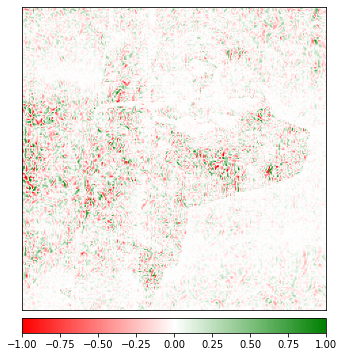

In [61]:
from captum.attr import IntegratedGradients
exp_ig_6 = IntegratedGradients(loaded_model)
attr_ig_6 = exp_ig_6.attribute(inputs[6].unsqueeze(0), target=61)
show_attr(attr_ig_6[0])

This time, we can see some shapes, the person and part of a pipe, however, I can say that only because I know the picture. But this time we can see, which regions of a picture were more influencing the decidion than others.

Kernel Shap attribution: 100%|██████████| 500/500 [01:24<00:00,  5.91it/s]


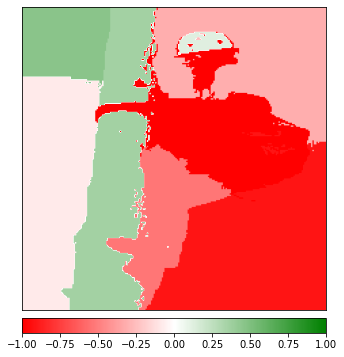

In [62]:
exp_ks_6_1 = KernelShap(loaded_model)

exp_ks_6_1 = exp_ks_6_1.attribute(
    inputs[6].unsqueeze(0), 
    target=61, 
    n_samples=500, 
    feature_mask=torch.as_tensor(mask_6),
    show_progress=True
  )

show_attr(exp_ks_6_1[0])

And SHAP explanation, without big surprises, performed best here, showing what a human would say about most important parts of a picture.

### Wrong classified picture

Now I would like to look closer on a picture with snowboard, which for human seems to be easy to recognize. On contary, the model had problems with predicting good label.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true label: snow boarding
pred label: ice climbing
tensor(79)
tensor(47)


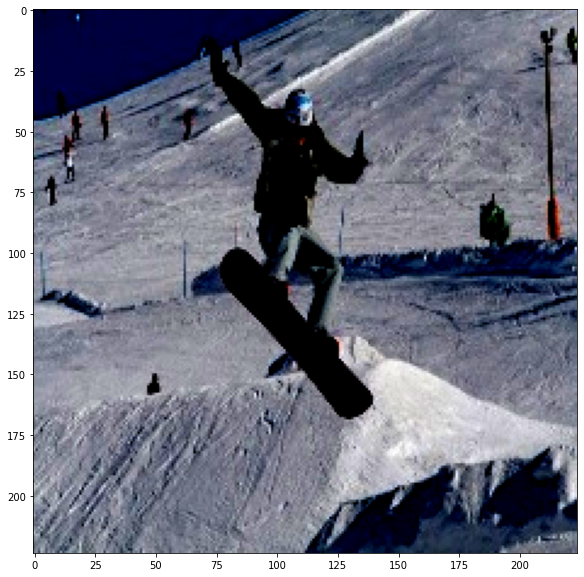

In [461]:
grid_test = torchvision.utils.make_grid(inputs[8], nrow=10)

plt.figure(figsize=(10,10))
plt.imshow(grid_test.cpu().permute(1,2,0))

print(f'true label: {classes[labels[8]]}')
print(f'pred label: {classes[pred[8]]}')
print(labels[8])
print(pred[8])

In [478]:
explainer_2 = Lime(loaded_model)
mask_2 = segmentation.quickshift(
    inputs[8].permute(1, 2, 0).double(), 
    kernel_size=15, #15
    max_dist=10, 
    ratio=0.7
  )


In [467]:
mask_2

array([[12, 12, 12, ..., 24, 24, 24],
       [12, 12, 12, ..., 24, 24, 24],
       [12, 12, 12, ..., 24, 24, 24],
       ...,
       [68, 68, 68, ..., 86, 86, 86],
       [68, 68, 68, ..., 86, 86, 86],
       [68, 68, 84, ..., 86, 86, 86]], dtype=int64)

In [479]:
attr_2 = explainer_2.attribute(
    inputs[8].unsqueeze(0),
    target=47, 
    n_samples=20, 
    feature_mask=torch.as_tensor(mask_2),
    show_progress=True
  )

Lime attribution: 100%|██████████| 20/20 [00:02<00:00,  6.73it/s]


In [480]:
np.max(attr_2.tolist())

0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


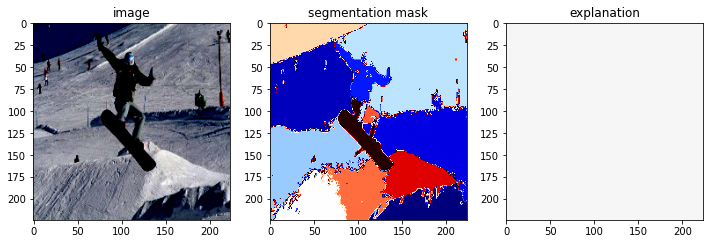

In [481]:
show_image_mask_explanation(inputs[8], mask_2, attr_2[0].mean(axis=0)*1000000)

Also this time LIME had problems giving a proof for the decision of a model. Even though the segmentation looks really cool.

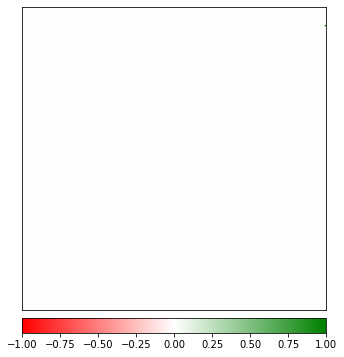

In [474]:
show_attr(attr_2[0])

In [494]:
explainer_2_2 = Lime(loaded_model)
attr_2_2 = explainer_2_2.attribute(
    inputs[8].unsqueeze(0),
    target=47, 
    n_samples=20, 
    feature_mask=torch.as_tensor(mask_2),
    show_progress=True
  )

Lime attribution: 100%|██████████| 20/20 [00:03<00:00,  5.98it/s]


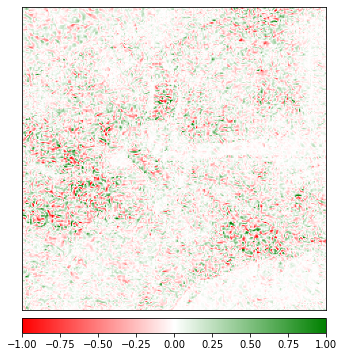

In [491]:
exp_ig_2 = IntegratedGradients(loaded_model)

attr_ig_2 = exp_ig_2.attribute(inputs[8].unsqueeze(0), target=47)
show_attr(attr_ig_2[0])

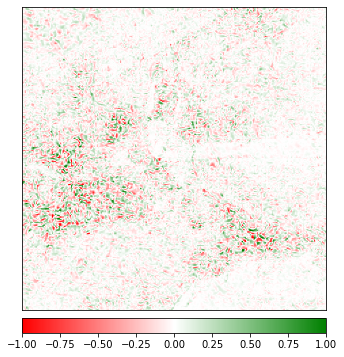

In [492]:
exp_ig_2 = IntegratedGradients(loaded_model)

attr_ig_2 = exp_ig_2.attribute(inputs[8].unsqueeze(0), target=79)
show_attr(attr_ig_2[0])

Also this time IntegratedGradien gave some messy output, only slightly showing, which regions were having more impact on decision. These regions seems to be similar for both true label and predicted (wrong) label.

Kernel Shap attribution: 100%|██████████| 300/300 [00:44<00:00,  6.75it/s]


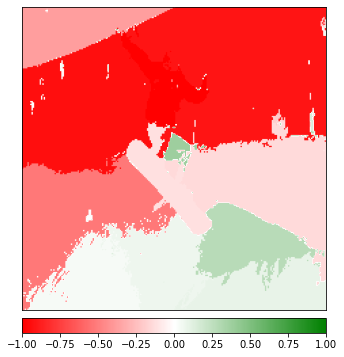

In [488]:
#for predicted, wrong label
from captum.attr import KernelShap
exp_ks_2_1 = KernelShap(loaded_model)

exp_ks_2_1 = exp_ks_2_1.attribute(
    inputs[8].unsqueeze(0), 
    target=47, 
    n_samples=300, 
    feature_mask=torch.as_tensor(mask_2),
    show_progress=True
  )

show_attr(exp_ks_2_1[0])

Kernel Shap attribution: 100%|██████████| 300/300 [00:58<00:00,  5.13it/s]


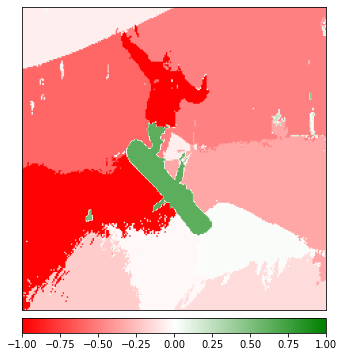

In [495]:
#for correct label, not predicted

from captum.attr import KernelShap
exp_ks_2_1 = KernelShap(loaded_model)

exp_ks_2_1 = exp_ks_2_1.attribute(
    inputs[8].unsqueeze(0), 
    target=79, 
    n_samples=300, 
    feature_mask=torch.as_tensor(mask_2),
    show_progress=True
  )

show_attr(exp_ks_2_1[0])

In this case, the result surprised me the most. Model explains, that the most good part for true label is a board, what makes a lot of sense. However, the amout of parts of a picture, which makes model think, it is not snowboard is too big. In this case, model says, that the predicion is 'ice climbing' which is not correct. However, on the explanation for this idea, model gives quite good resons, that means, part of a hill with snow, in right bottom corner.

### Summary

It was really interesting to see, which parts of a picture made model make decision about the prediction. A bit disappointing was, that not for all images, LIME method was able to give any ideas. Also, IntegratedGradients was nearly in all cases too messy, to think of any shapes, that might be on a picture, shapes which made model think of a solution. The best method, I like it the most, was SHAP. Nearly in all cases, the explanation were logically acceptable for me, as things that I would also say, when ased, why I think that there is snowboarding person or climbing one. The most surprising was the last one, wrong classified, even though board was correctly found. I hope, that this situation took only place bacause the model had only 75% accuracy on this test batch. I wish training of this model took less (nearly 11h on my computer to calculate only part of a epoch), so I would be able to wait longer and see the explanations of a model ahving over 90% of accuracy (in the source mentioned before, they made it so good).